# Lab 4

In [1]:
import os
import operator
import regex as re
import numpy as np
import matplotlib.pyplot as plt
from keras import Input
from keras.models import Sequential
from keras.layers import Embedding, Dense, LSTM
from keras.layers import SimpleRNN, Bidirectional, Dropout
from keras.utils.np_utils import to_categorical
from keras.preprocessing.sequence import pad_sequences

os.environ['KMP_DUPLICATE_LIB_OK']='True'

Using TensorFlow backend.


### Collecting the Embeddings

1. Download the GloVe embeddings 6B from https://nlp.stanford.edu/projects/glove/ and keep the 100d vectors.
2. Write a function that reads GloVe embeddings and store them in a dictionary, where the keys will be the words and the values, the embeddings.
3. Using a cosine similarity, compute the 5 closest words to the words table, france, and sweden.


Listing 6.10 Parsing the GloVe word-embeddings file

In [4]:
glove_dir = '/Users/madeleinejansson/Documents/AppliedML/A4/glove.6B'
embeddings_index = {}
f = open(os.path.join(glove_dir, 'glove.6B.100d.txt'))
for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
f.close()
print('Found %s word vectors.' % len(embeddings_index))


Found 400000 word vectors.


In [5]:
print(embeddings_index['france'])

[ 0.4359    -0.04961    0.31388    0.6056     0.36372   -0.03974
  0.42844    0.58571   -0.0048055 -0.24868   -0.069374   0.036042
 -0.68352    0.55531   -0.36235    0.13997    0.020455  -0.82498
 -0.68761    0.28685    0.37247    0.62814    0.45655    0.11955
  1.087     -1.3191     0.1611    -0.37508    1.1136    -0.8442
 -0.78734   -0.61974   -0.48193   -0.76358    0.55343    0.80071
  0.53818   -0.13143   -1.2196    -0.10605   -0.60646   -0.45015
  0.34853   -0.49596    0.31408    0.24088    0.28625   -0.11539
  0.40018   -0.94102    0.30618    1.3605    -0.75011    1.3509
 -1.1497    -2.6059    -0.078406   0.09977    0.93239    0.15718
  1.0857    -0.52454    0.14787   -0.61679    0.49391    0.38589
 -1.264      0.78695    0.13566    0.22713    0.49846   -0.25495
 -0.88281   -0.17737    0.50366   -0.094379   0.65361   -0.14926
 -0.79488    0.42061    0.92563   -0.5842    -0.21701    0.56262
 -1.0399    -0.97772   -0.34684    0.58105   -0.38675   -0.42649
 -0.35594   -0.45715    0.

A cosine similiarity between two vectors

In [6]:
def cos_sim(v1, v2):
    
    den = np.dot(v1, v2)
    num = np.linalg.norm(v1)*np.linalg.norm(v2)
    return den/num


In [7]:
cos_sim(embeddings_index['france'], embeddings_index['france'])

0.99999994

Extracts the five most similar words to a given

In [8]:
def five_words(word, dictionary):
    compared_dic = {}
    for i in dictionary.keys():
        if i == word:
            continue
        angle = cos_sim(dictionary[word], dictionary[i])
        compared_dic[i] = angle
    
    sorted_dic = sorted(compared_dic.items(), key=operator.itemgetter(1), reverse=True)
    return sorted_dic[0:5] 
            

In [9]:
five_words('france', embeddings_index)

[('belgium', 0.8076423),
 ('french', 0.8004377),
 ('britain', 0.79505277),
 ('spain', 0.7557464),
 ('paris', 0.74815863)]

In [10]:
five_words('table', embeddings_index)

[('tables', 0.80211616),
 ('place', 0.6582379),
 ('bottom', 0.65597206),
 ('room', 0.65436906),
 ('side', 0.6433667)]

In [11]:
five_words('sweden', embeddings_index)

[('denmark', 0.8624401),
 ('norway', 0.80732495),
 ('finland', 0.7906495),
 ('netherlands', 0.74684644),
 ('austria', 0.74668366)]

### Reading the Corpus and Building Indices
You will read the corpus with programs available from https://github.com/pnugues/edan95. These programs will enable you to load the files in the form of a list of dictionaries.

1. Write a function that for each sentence returns the x and y lists of symbols consisting of words and NER tags.
2. Apply this function to your datasets so that you create X and Y lists of lists consisting of words and NER tags
3. Create a vocabulary of all the words observed in the training set and the words in GloVe.
4. Create indices and inverted indices for the words and the NER: i.e. you will associate each word with a number. You will use index 0 for the padding symbol and 1 for unknown words.


Reading the corpus

In [12]:
BASE_DIR = '/Users/madeleinejansson/Documents/AppliedML/A4/conll003-englishversion/'

def load_conll2003_en():
    train_file = BASE_DIR + 'train.txt'
    dev_file = BASE_DIR + 'valid.txt'
    test_file = BASE_DIR + 'test.txt'
    column_names = ['form', 'ppos', 'pchunk', 'ner']
    train_sentences = open(train_file).read().strip()
    dev_sentences = open(dev_file).read().strip()
    test_sentences = open(test_file).read().strip()
    return train_sentences, dev_sentences, test_sentences, column_names

The dictorizer that transforms the CoNLL files into dictionaries

In [13]:
class Token(dict):
    pass

class CoNLLDictorizer:

    def __init__(self, column_names, sent_sep='\n\n', col_sep=' +'):
        self.column_names = column_names
        self.sent_sep = sent_sep
        self.col_sep = col_sep

    def fit(self):
        pass

    def transform(self, corpus):
        corpus = corpus.strip()
        sentences = re.split(self.sent_sep, corpus)
        return list(map(self._split_in_words, sentences))

    def fit_transform(self, corpus):
        return self.transform(corpus)

    def _split_in_words(self, sentence):
        rows = re.split('\n', sentence)
        return [Token(dict(zip(self.column_names,
                               re.split(self.col_sep, row))))
                for row in rows]

Loading the CoNLL2003 data set

In [14]:
train_sentences, dev_sentences, test_sentences, column_names = load_conll2003_en()

conll_dict = CoNLLDictorizer(column_names, col_sep=' +')
train_dict = conll_dict.transform(train_sentences)
test_dict = conll_dict.transform(test_sentences)
dev_dict = conll_dict.transform(dev_sentences)

In [15]:
print(train_dict[0])
print(train_dict[1])

[{'form': '-DOCSTART-', 'ppos': '-X-', 'pchunk': '-X-', 'ner': 'O'}]
[{'form': 'EU', 'ppos': 'NNP', 'pchunk': 'B-NP', 'ner': 'B-ORG'}, {'form': 'rejects', 'ppos': 'VBZ', 'pchunk': 'B-VP', 'ner': 'O'}, {'form': 'German', 'ppos': 'JJ', 'pchunk': 'B-NP', 'ner': 'B-MISC'}, {'form': 'call', 'ppos': 'NN', 'pchunk': 'I-NP', 'ner': 'O'}, {'form': 'to', 'ppos': 'TO', 'pchunk': 'B-VP', 'ner': 'O'}, {'form': 'boycott', 'ppos': 'VB', 'pchunk': 'I-VP', 'ner': 'O'}, {'form': 'British', 'ppos': 'JJ', 'pchunk': 'B-NP', 'ner': 'B-MISC'}, {'form': 'lamb', 'ppos': 'NN', 'pchunk': 'I-NP', 'ner': 'O'}, {'form': '.', 'ppos': '.', 'pchunk': 'O', 'ner': 'O'}]


Building the sequences

In [16]:
def build_sequences(corpus_dict, key_x='form', key_y='pos', tolower=True):
    """
    Creates sequences from a list of dictionaries
    :param corpus_dict:
    :param key_x:
    :param key_y:
    :return:
    """
    X = []
    Y = []
    for sentence in corpus_dict:
        x = [word[key_x] for word in sentence]
        y = [word[key_y] for word in sentence]
        if tolower:
            x = list(map(str.lower, x))
        X += [x]
        Y += [y]
    return X, Y

We build the words and NER sequence tags (collner 2003)

In [17]:
X_words, Y_ner = build_sequences(train_dict, key_x='form', key_y='ner')

X_words_test, Y_ner_test = build_sequences(test_dict, key_x='form', key_y='ner')

X_dev_words, Y_dev_ner = build_sequences(dev_dict, key_x='form', key_y='ner')

In [116]:
print('First sentence, words', X_words[1])
print('First sentence, NER', Y_ner[1])

First sentence, words ['eu', 'rejects', 'german', 'call', 'to', 'boycott', 'british', 'lamb', '.']
First sentence, NER ['B-ORG', 'O', 'B-MISC', 'O', 'O', 'O', 'B-MISC', 'O', 'O']


Extract the list of unique words and NER (collner 2003)

In [18]:
word_set = sorted(list(set([item for sublist in X_words for item in sublist])))
ner_set = sorted(list(set([item for sublist in Y_ner for item in sublist])))

word_set_test = sorted(list(set([item for sublist in X_words_test for item in sublist])))
ner_set_test = sorted(list(set([item for sublist in Y_ner_test for item in sublist])))

word_set_dev = sorted(list(set([item for sublist in X_dev_words for item in sublist])))
ner_set_dev = sorted(list(set([item for sublist in Y_dev_ner for item in sublist])))


In [85]:
print(len(ner_set))
print(len(word_set))

9
21010


Extract the keys that are words (GloVe)

In [19]:
glove_set = sorted([key for key in embeddings_index.keys()]) 

glove_set.extend(word_set)
voc = sorted(set(glove_set))

rev_voc_idx = dict(enumerate(voc, start=2))

voc_idx = {v: k for k, v in rev_voc_idx.items()}
len(voc)

402595

Building the indices, pairing padding to 0 and unknown to 1

In [20]:
# Train
rev_word_idx = dict(enumerate(voc, start=2))
rev_ner_idx = dict(enumerate(ner_set, start=2))

word_idx = {v: k for k, v in rev_word_idx.items()}
ner_idx = {v: k for k, v in rev_ner_idx.items()}

# Test
rev_word_idx_test = dict(enumerate(voc, start=2))
rev_ner_idx_test = dict(enumerate(ner_set_test, start=2))

word_idx_test = {v: k for k, v in rev_word_idx_test.items()}
ner_idx_test = {v: k for k, v in rev_ner_idx_test.items()}

# Development
rev_word_idx_dev = dict(enumerate(voc, start=2))
rev_ner_idx_dev = dict(enumerate(ner_set_dev, start=2))

word_idx_dev = {v: k for k, v in rev_word_idx_dev.items()}
ner_idx_dev = {v: k for k, v in rev_ner_idx_dev.items()}

In [21]:
word_idx

{'!': 2,
 '!!': 3,
 '!!!': 4,
 '!!!!': 5,
 '!!!!!': 6,
 '!?': 7,
 '!?!': 8,
 '"': 9,
 '#': 10,
 '##': 11,
 '###': 12,
 '#a': 13,
 '#aabccc': 14,
 '#b': 15,
 '#c': 16,
 '#cc': 17,
 '#ccc': 18,
 '#cccccc': 19,
 '#ccccff': 20,
 '#d': 21,
 '#daa': 22,
 '#dcdcdc': 23,
 '#e': 24,
 '#f': 25,
 '#faf': 26,
 '#ff': 27,
 '#ffffff': 28,
 '#m': 29,
 '#p': 30,
 '#s': 31,
 '#the': 32,
 '#ukqa': 33,
 '#ukqaqfqs': 34,
 '#ukqaqs': 35,
 '#ukqaqsqf': 36,
 '#ukqaqsqm': 37,
 '#ukqaqtqszbzszr': 38,
 '#ukqec': 39,
 '#ukqeqtqszb': 40,
 '$': 41,
 '%': 42,
 '&': 43,
 '&#8211;': 44,
 '&#8217;': 45,
 '&#8220;': 46,
 '&#8221;': 47,
 '&amp;': 48,
 "'": 49,
 "''": 50,
 "'00": 51,
 "'01": 52,
 "'02": 53,
 "'03": 54,
 "'04": 55,
 "'05": 56,
 "'06": 57,
 "'07": 58,
 "'08": 59,
 "'09": 60,
 "'10": 61,
 "'11": 62,
 "'12": 63,
 "'13": 64,
 "'14": 65,
 "'15": 66,
 "'20": 67,
 "'20s": 68,
 "'25": 69,
 "'27": 70,
 "'28": 71,
 "'29": 72,
 "'30": 73,
 "'30s": 74,
 "'32": 75,
 "'34": 76,
 "'36": 77,
 "'37": 78,
 "'38": 79,
 "'39

### Building the Embedding Matrix

1. Create a matrix of dimensions (M, N), where M, will the size of the vocabulary: The unique words in the training set and the words in GloVe, and N, the dimension of the embeddings. Initialize it with random values.
2. Fill the matrix with the GloVe embeddings. You will use the indices from the previous section.


Listing 6.11 Preparing the GloVe word-embeddings matrix

In [22]:
max_word = len(voc) + 2 # M
embedding_dim = len(embeddings_index['france']) # N
embedding_matrix = np.random.rand(max_word,embedding_dim)

for word, i in voc_idx.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector

### Creating the X and Y Sequences

You will now create the input and output sequences with numerical indices

1. Convert the X and Y lists of symbols in lists of numbers using the indices you created.
2. Pad the sentences using the pad_sequences function.
3. Do the same for the development set.


Convert the matrices into numbers. Before: We have the symbols. After: We have the indices

Train set

In [23]:
X_words_idx = [list(map(lambda x: word_idx.get(x, 1), x)) for x in X_words]
Y_ner_idx = [list(map(lambda x: ner_idx.get(x, 1), x)) for x in Y_ner]

In [24]:
print(X_words_idx[1])
print(X_words_idx[2])
Y_ner_idx[1]

[142143, 307143, 161836, 91321, 363368, 83766, 85852, 218260, 936]
[284434, 79019]


[4, 10, 3, 10, 10, 10, 3, 10, 10]

We pad the sequences

In [25]:
X_words_idx = pad_sequences(X_words_idx, maxlen=150)
Y_ner_idx = pad_sequences(Y_ner_idx, maxlen=150)

Test set

In [26]:
X_words_idx_test = [list(map(lambda x: word_idx.get(x, 1), x)) for x in X_words_test]
Y_ner_idx_test = [list(map(lambda x: ner_idx.get(x, 1), x)) for x in Y_ner_test]

In [27]:
X_test_words_idx = pad_sequences(X_words_idx_test, maxlen=150)
Y_test_ner_idx = pad_sequences(Y_ner_idx_test, maxlen=150)

Development set

In [28]:
X_dev_words_idx = [list(map(lambda x: word_idx.get(x, 1), x)) for x in X_dev_words]
Y_dev_ner_idx = [list(map(lambda x: ner_idx.get(x, 1), x)) for x in Y_dev_ner]

In [29]:
X_dev_words_idx = pad_sequences(X_dev_words_idx, maxlen=150)
Y_dev_ner_idx = pad_sequences(Y_dev_ner_idx, maxlen=150)

### Building a Simple Recurrent Neural Network

1. Create a simple recurrent network and train a model with the train set. As layers, you will use Embedding, SimpleRNN, and Dense.
2. Compile and fit your network. You will report the training and validation losses and accuracies and comment on the possible overfit.
3. Apply your network to the test set and report the accuracy you obtained. You will use the evaluate method.

Defining a model

In [97]:
text_vocabulary_size = len(voc) + 2

model = Sequential()
model.add(Embedding(text_vocabulary_size,
                    embedding_dim,
                    input_length=150,
                    mask_zero=True))

model.add(SimpleRNN(32, return_sequences=True))
#model.add(Bidirectional(SimpleRNN(32, return_sequences=True)))
#model.add(Dropout(0.25))
model.add(Dense(len(ner_set) + 2, activation='softmax'))

Loading pretrained word embeddings into the Embedding layer (frozen)

In [98]:
model.layers[0].set_weights([embedding_matrix])
model.layers[0].trainable = False

Compiling 

In [99]:
model.compile(optimizer='rmsprop',
              loss='categorical_crossentropy',
              metrics=['acc'])

Converting arrays of labeled data to one-hot vector

In [31]:
Y_train = to_categorical(Y_ner_idx, num_classes = len(ner_set)+2)
X_train = X_words_idx

Y_test = to_categorical(Y_test_ner_idx, num_classes = len(ner_set)+2)
X_test = X_test_words_idx

Y_val = to_categorical(Y_dev_ner_idx, num_classes = len(ner_set)+2)
X_val = X_dev_words_idx

In [33]:
print(Y_train[1])
len(Y_train)

[[1. 0. 0. ... 0. 0. 0.]
 [1. 0. 0. ... 0. 0. 0.]
 [1. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 1.]
 [0. 0. 0. ... 0. 0. 1.]]


14987

Fit the model

In [102]:
history = model.fit(X_train, 
                    Y_train,
                    epochs=10, 
                    batch_size=128,
                    validation_data=(X_val, Y_val)) 

Train on 14987 samples, validate on 3466 samples
Epoch 1/10
14987/14987 [==============================] - 18s 1ms/step - loss: 0.0628 - acc: 0.8299 - val_loss: 0.0406 - val_acc: 0.8962
Epoch 2/10
14987/14987 [==============================] - 15s 1ms/step - loss: 0.0308 - acc: 0.9087 - val_loss: 0.0297 - val_acc: 0.9195
Epoch 3/10
14987/14987 [==============================] - 15s 990us/step - loss: 0.0248 - acc: 0.9232 - val_loss: 0.0256 - val_acc: 0.9299
Epoch 4/10
14987/14987 [==============================] - 15s 993us/step - loss: 0.0221 - acc: 0.9314 - val_loss: 0.0235 - val_acc: 0.9358
Epoch 5/10
14987/14987 [==============================] - 15s 990us/step - loss: 0.0204 - acc: 0.9371 - val_loss: 0.0221 - val_acc: 0.9394
Epoch 6/10
14987/14987 [==============================] - 15s 982us/step - loss: 0.0192 - acc: 0.9407 - val_loss: 0.0214 - val_acc: 0.9417
Epoch 7/10
14987/14987 [==============================] - 15s 970us/step - loss: 0.0183 - acc: 0.9432 - val_loss: 0.0210 

Plot the results

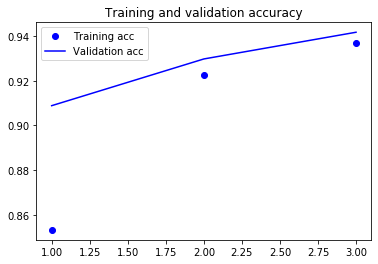

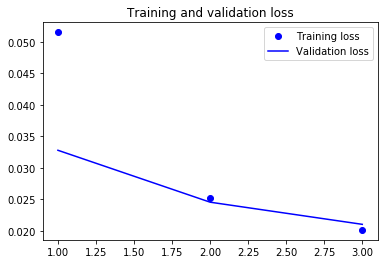

In [38]:
acc = history.history['acc'] 
val_acc = history.history['val_acc'] 
loss = history.history['loss'] 
val_loss = history.history['val_loss']
epochs = range(1, len(acc) + 1)
plt.plot(epochs, acc, 'bo', label='Training acc') 
plt.plot(epochs, val_acc, 'b', label='Validation acc') 
plt.title('Training and validation accuracy') 
plt.legend()
plt.figure()
plt.plot(epochs, loss, 'bo', label='Training loss') 
plt.plot(epochs, val_loss, 'b', label='Validation loss') 
plt.title('Training and validation loss') 
plt.legend()
plt.show()

Evaluating the test accuracy

In [118]:
test_loss, test_acc = model.evaluate(X_test, Y_test)
test_acc

3684/3684 [==============================] - 3s 788us/step


0.9405134320259094

### Evaluating your System

You will use the official script to evaluate the performance of your system

1. Use the predict method to predict the tags of the whole test set
2. Write your results in a file, where the two last columns will be the hand-annotated tag and the predicted tag. The fields must be separated by a space.
3. Apply conlleval to your output. Report the F1 result.
4. Try to improve your model by modifying some parameters, adding layers, adding Bidirectional and Dropout.
5. Evaluate your network again


In [119]:
y_pred = model.predict(X_test)
np.shape(y_pred)

(3684, 150, 11)

Remove padding

In [120]:
ner_pred_num = []
for sent_nbr, sent_ner_predictions in enumerate(y_pred):
    ner_pred_num += [sent_ner_predictions[-len(X_words_test[sent_nbr]):]] 

Convert NER indices to symbols

In [121]:
ner_pred = []
for sentence in ner_pred_num:
    ner_pred_idx = list(map(np.argmax, sentence))
    ner_pred_cat = list(map(rev_ner_idx.get, ner_pred_idx))
    ner_pred += [ner_pred_cat]

print(ner_pred[:2])
print(Y_ner_test[:2])

[['O'], ['O', 'O', 'B-LOC', 'O', 'O', 'O', 'O', 'B-LOC', 'O', 'O', 'O', 'O']]
[['O'], ['O', 'O', 'B-LOC', 'O', 'O', 'O', 'O', 'B-PER', 'O', 'O', 'O', 'O']]


Two last columns will be the hand-annotated tag and the predicted tag, save to txt file

In [122]:
f_out = open('RNN', 'w')
for i in range(len(X_words_test)): # For each sentence
    for j in range(len(X_words_test[i])): # Fore each word
        word = str(X_words_test[i][j])
        NER = str(Y_ner_test[i][j]) 
        PNER = str(ner_pred[i][j])
        f_out.write(word + ' ' + NER + ' ' + PNER + '\n')
    f_out.write('\n')  
f_out.close()

In [ ]:
Conlleval applied to output

In [123]:
!perl ./conlleval.pl <RNN

processed 46666 tokens with 5648 phrases; found: 5362 phrases; correct: 3915.
accuracy:  94.05%; precision:  73.01%; recall:  69.32%; FB1:  71.12
              LOC: precision:  76.00%; recall:  80.10%; FB1:  77.99  1758
             MISC: precision:  63.51%; recall:  50.57%; FB1:  56.30  559
              ORG: precision:  63.44%; recall:  56.11%; FB1:  59.55  1469
              PER: precision:  81.98%; recall:  79.90%; FB1:  80.93  1576


### Building a LSTM Network

1. Create a simple LSTM network and train a model with the train set. As layers, you will use Embedding, LSTM, and Dense.
2. Apply conlleval to your output. Report the F1 result.
3. Try to improve your model by modifying some parameters, adding layers, adding Bidirectional, Dropout, possibly mixing SimpleRNN.
4. Apply your network to the test set and report the accuracy you obtained. you need to reach a F1 of 82 to pass.


Creating the model

In [23]:
text_vocabulary_size = len(voc) + 2

model = Sequential()
model.add(Embedding(text_vocabulary_size,
                    embedding_dim,
                    input_length=150,
                    mask_zero=True))
model.add(Bidirectional(LSTM(100, return_sequences=True)))
model.add(Bidirectional(SimpleRNN(100, return_sequences=True)))
model.add(Dense(100*2, activation='relu'))
model.add(Dropout(0.50))
model.add(Dense(len(ner_set) + 2, activation='softmax'))

Loading pretrained word embeddings into the Embedding layer (frozen)

In [24]:
model.layers[0].set_weights([embedding_matrix])
model.layers[0].trainable = False

Compiling

In [25]:
model.compile(optimizer='rmsprop',
              loss='categorical_crossentropy',
              metrics=['acc'])

Fit the model

In [26]:
history = model.fit(X_train, 
                    Y_train,
                    epochs=12, 
                    batch_size=128,
                    validation_data=(X_val, Y_val)) 

Train on 14987 samples, validate on 3466 samples
Epoch 1/12
14987/14987 [==============================] - 206s 14ms/step - loss: 0.0402 - acc: 0.8842 - val_loss: 0.0301 - val_acc: 0.9178
Epoch 2/12
14987/14987 [==============================] - 208s 14ms/step - loss: 0.0155 - acc: 0.9502 - val_loss: 0.0137 - val_acc: 0.9605
Epoch 3/12
14987/14987 [==============================] - 198s 13ms/step - loss: 0.0114 - acc: 0.9626 - val_loss: 0.0368 - val_acc: 0.8886
Epoch 4/12
14987/14987 [==============================] - 203s 14ms/step - loss: 0.0093 - acc: 0.9687 - val_loss: 0.0121 - val_acc: 0.9642
Epoch 5/12
14987/14987 [==============================] - 204s 14ms/step - loss: 0.0077 - acc: 0.9741 - val_loss: 0.0128 - val_acc: 0.9671
Epoch 6/12
14987/14987 [==============================] - 201s 13ms/step - loss: 0.0065 - acc: 0.9775 - val_loss: 0.0102 - val_acc: 0.9718
Epoch 7/12
14987/14987 [==============================] - 200s 13ms/step - loss: 0.0056 - acc: 0.9808 - val_loss: 0.0

In [34]:
acc = history.history['acc'] 
val_acc = history.history['val_acc'] 
loss = history.history['loss'] 
val_loss = history.history['val_loss']
epochs = range(1, len(acc) + 1)
plt.plot(epochs, acc, 'bo', label='Training acc') 
plt.plot(epochs, val_acc, 'b', label='Validation acc') 
plt.title('Training and validation accuracy') 
plt.legend()
plt.figure()
plt.plot(epochs, loss, 'bo', label='Training loss') 
plt.plot(epochs, val_loss, 'b', label='Validation loss') 
plt.title('Training and validation loss') 
plt.legend()
plt.show()

NameError: name 'history' is not defined

Predicts the outcome

In [35]:
y_pred = model.predict(X_test)
np.shape(y_pred)

NameError: name 'model' is not defined

Remove padding

In [28]:
ner_pred_num = []
for sent_nbr, sent_ner_predictions in enumerate(y_pred):
    ner_pred_num += [sent_ner_predictions[-len(X_words_test[sent_nbr]):]] 

Convert NER indices to symbols

In [29]:
ner_pred = []
for sentence in ner_pred_num:
    ner_pred_idx = list(map(np.argmax, sentence))
    ner_pred_cat = list(map(rev_ner_idx.get, ner_pred_idx))
    ner_pred += [ner_pred_cat]

Save to txt file

In [30]:
f_out = open('LSTM', 'w')
for i in range(len(X_words_test)): # For each sentence
    for j in range(len(X_words_test[i])): # Fore each word
        word = str(X_words_test[i][j])
        NER = str(Y_ner_test[i][j]) 
        PNER = str(ner_pred[i][j])
        f_out.write(word + ' ' + NER + ' ' + PNER + '\n')
    f_out.write('\n')  
f_out.close()

Conlleval applied to output

In [31]:
!perl ./conlleval.pl <LSTM

processed 46666 tokens with 5648 phrases; found: 5819 phrases; correct: 4721.
accuracy:  96.37%; precision:  81.13%; recall:  83.59%; FB1:  82.34
              LOC: precision:  83.44%; recall:  89.99%; FB1:  86.59  1799
             MISC: precision:  68.73%; recall:  67.95%; FB1:  68.34  694
              ORG: precision:  75.06%; recall:  78.27%; FB1:  76.63  1732
              PER: precision:  90.53%; recall:  89.24%; FB1:  89.88  1594
